In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import wget
import os
from scipy.stats import chi2
from scipy.stats import t
from tqdm import tqdm
import sympy as sym
import corner

In [2]:
sample = np.array([0.974,0.950,0.932,1.104,1.038,0.920,0.935,0.907,0.810,0.915])

In [3]:
mean = np.mean(sample)
print(mean)

0.9484999999999999


In [4]:
def Resample(sample):
    
    resample_ = np.random.choice( sample, size = len(sample), replace = True )
    return resample_

In [5]:
np.mean(Resample(sample))

0.9335000000000001

In [6]:
def Bootstrapping(sample,N=10000):
    
    Mean_Dist = np.zeros(N)
    
    for i in tqdm(range(N)):
        resample = Resample(sample)
        Mean_Dist[i] = np.mean(resample)
        
    return Mean_Dist

In [7]:
Mean_Dist = Bootstrapping(sample)

100%|██████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 14637.63it/s]


In [8]:
mean = np.percentile(Mean_Dist,50)
print(mean)
q1 = np.quantile( a = Mean_Dist, q=[0.16,0.84] )
q2 = np.quantile( a = Mean_Dist, q=[0.023,0.977] )

q1

0.9481999999999999


array([0.925184, 0.9725  ])

In [9]:
Mean_Dist = Bootstrapping(sample)

100%|██████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 13827.24it/s]


In [10]:
errorinf = mean-q1[0]
errorsup = q1[1] - mean
print(errorinf,errorsup)

0.023015999999999925 0.02429999999999999


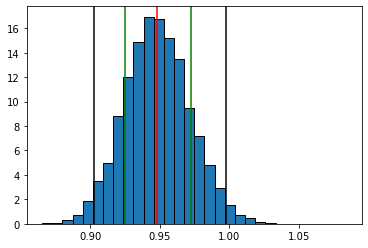

In [11]:
plt.hist(Mean_Dist, bins=30, density=True, ec='k')
plt.axvline(x=mean,color='r')
plt.axvline(x=q1[0],color='g')
plt.axvline(x=q1[1],color='g')
plt.axvline(x=q2[0],color='k')
plt.axvline(x=q2[1],color='k')

$$ \hat{\mu} = 0.948_{0.022}^{0.023}  at 68\% CL $$

In [12]:
# Descargamos data
if not path.exists('Data'):
    os.mkdir('Data')

!rm Data/*

file = 'Data/data.csv'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosCuadratico.txt'
#url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosLineal.txt'

if not path.exists(file):
    Path_ = wget.download(url,file)
    print('File loaded')
else:
    Path_ = file

100% [..................................................................................] 521 / 521File loaded


In [13]:
Data = np.loadtxt(Path_)

In [14]:
x = Data[:,0]
y = Data[:,1]
N = len(x)
sigma = np.random.uniform(1,4,size=N)
sigma

array([2.49227005, 2.79573719, 1.63117417, 3.14879308, 3.80978375,
       2.39130957, 2.40422797, 3.84195106, 1.94338837, 3.30282334,
       2.12228047, 1.44870658, 2.23314824, 1.75638558, 1.40194518,
       3.77292437, 1.15334293, 2.44005667, 2.94557983, 3.4810117 ])

In [15]:
def GetFit(x,y,n=3):
    
    size = len(x)
    b = y
    
    A = np.ones((size,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**(i)

    # Hacer ajuste cuadratico
    
    M = np.dot(A.T,A)
    bt = np.dot(A.T,b)
    
    xsol = np.linalg.solve(M,bt)

    return xsol

In [16]:
n = 2 # order of the polynomial
param = GetFit(x,y,n=n)
print(param)

[1.22132054 6.09075205 2.9565874 ]


In [17]:
def GetModel(x,p):
    
    y = 0.
    for i in range(len(p)):
        y += p[i]*x**i
    
    return y

In [18]:
X = sym.Symbol('x',real=True)
GetModel(X,param)

2.95658740177385*x**2 + 6.0907520463624*x + 1.2213205361703

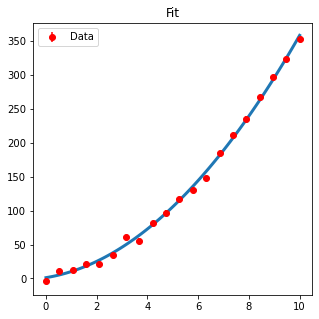

In [19]:
t = np.linspace(np.min(x),np.max(x),100)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x,y,yerr=sigma,fmt='o',color='r',label='Data')
ax.set_title('Fit')
ax.plot(t,GetModel(t,param),lw=3) 
#ax.plot(t,GetModel(t,param), label="Parameters: {0}".format(np.round(param,2))) 
ax.legend(loc=0)

In [20]:
def GetChi2(x,y,sigma,p,reducido=True):
    
    df = (len(x) - len(p) - 1) 
    
    if not reducido:
        return np.sum( ( ( y - GetModel(x,p) )/sigma )**2 ) , df
    else:   
        return np.sum( ( ( y - GetModel(x,p) )/sigma )**2 ) / df ,df

In [21]:
param = GetFit(x,y,n)
Chi2,df = GetChi2(x,y,sigma,param)
print(Chi2)

6.772729108343298


# Bootstraping

In [22]:
dict1 = dict(zip(x,y))
#dict1

In [23]:
def GetBootstrapping(x,n=3,Ntrials=int(3e4)):
    
    Values = np.zeros( (Ntrials, n+1) )
    
    for i in tqdm(range(Ntrials)):
        
        x1 = Resample(x)
        
        y1 = np.array([])
        
        for j in x1:
            y1 = np.append(y1,dict1[j])
            
        p = GetFit(x1,y1,n)
        
        Values[i] = p
        
    return Values

In [24]:
Mean_Dist = GetBootstrapping(x,n=n)

100%|███████████████████████████████████████████████████████| 30000/30000 [00:10<00:00, 2740.72it/s]


[1.43413497 5.95482673 2.97023366]


Text(0.5, 0, 'step number')

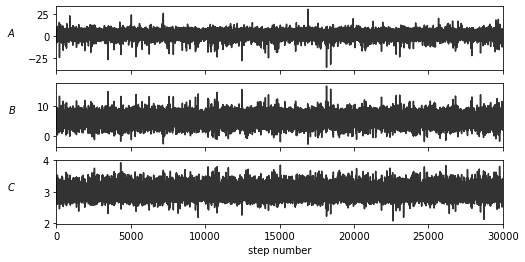

In [25]:
params = np.percentile(Mean_Dist,50,axis=0)
print(params)
fig, axes = plt.subplots(len(params), figsize=(8, 4), sharex=True)
labels = ["$A$","$B$","$C$"]
for i in range(len(params)):
    ax = axes[i]
    ax.plot(Mean_Dist[:,i], 'k', alpha=0.8)
    ax.set_xlim(0, len(Mean_Dist))
    ax.set_ylabel(labels[i], rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

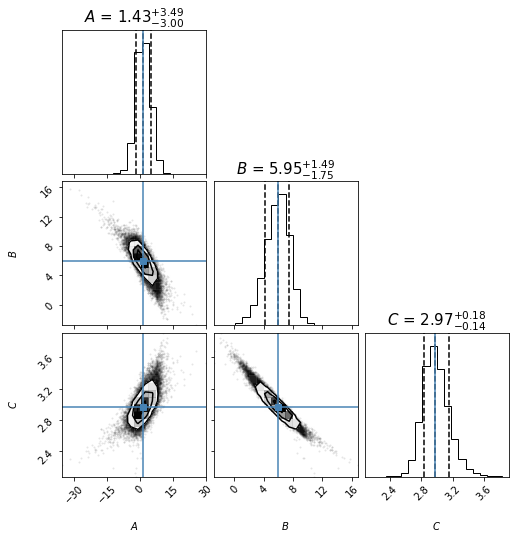

In [26]:
truths = np.percentile(Mean_Dist,50, axis=0)
figure = corner.corner(Mean_Dist, 
                       truths=truths, 
                       labels=labels, 
                       quantiles=[0.16,0.5,0.84], 
                       show_titles=True,
                       title_kwargs={"fontsize":15})

In [27]:
mean = np.percentile(Mean_Dist, 50, axis=0 )
mean

array([1.43413497, 5.95482673, 2.97023366])

In [28]:
q1 = np.quantile( a = Mean_Dist, q=[0.16,0.84], axis=0 )
q1

array([[-1.56263963,  4.20878909,  2.82684735],
       [ 4.9229118 ,  7.44740522,  3.14577184]])

In [29]:
errorsup = q1[1] - mean
errorinf = mean - q1[0]
print(errorsup)
print(errorinf)

[3.48877683 1.49257848 0.17553818]
[2.99677459 1.74603764 0.14338631]


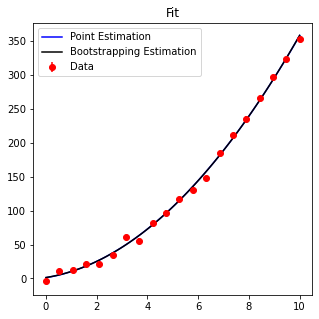

In [30]:
t = np.linspace(np.min(x),np.max(x),100)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x,y,yerr=sigma,fmt='o',color='r',label='Data')
ax.set_title('Fit')


ax.plot(t,GetModel(t,param),color='b', label='Point Estimation') 
bootsparam=[i for i in mean]
ax.plot(t,GetModel(t,bootsparam),color='k', label='Bootstrapping Estimation') 
ax.legend(loc=0)

<ErrorbarContainer object of 3 artists>

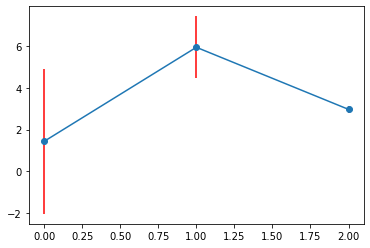

In [31]:
p1 = np.arange(0,len(mean),1)
plt.errorbar(p1,mean,yerr=errorsup,marker='o',ecolor='r')

# Varianza

In [34]:
A = np.ones((len(x),n+1))

for i in range(1,n+1):
    A[:,i] = x**i

A

array([[  1.        ,   0.        ,   0.        ],
       [  1.        ,   0.5263158 ,   0.27700832],
       [  1.        ,   1.052632  ,   1.10803413],
       [  1.        ,   1.578947  ,   2.49307363],
       [  1.        ,   2.105263  ,   4.4321323 ],
       [  1.        ,   2.631579  ,   6.92520803],
       [  1.        ,   3.157895  ,   9.97230083],
       [  1.        ,   3.684211  ,  13.57341069],
       [  1.        ,   4.210526  ,  17.7285292 ],
       [  1.        ,   4.736842  ,  22.43767213],
       [  1.        ,   5.263158  ,  27.70083213],
       [  1.        ,   5.789474  ,  33.5180092 ],
       [  1.        ,   6.315789  ,  39.88919069],
       [  1.        ,   6.842105  ,  46.81440083],
       [  1.        ,   7.368421  ,  54.29362803],
       [  1.        ,   7.894737  ,  62.3268723 ],
       [  1.        ,   8.421053  ,  70.91413363],
       [  1.        ,   8.947368  ,  80.05539413],
       [  1.        ,   9.473684  ,  89.75068853],
       [  1.        ,  10.     